# Function Interpolation

Interpolate a function via splines, GPs or GAMs

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from csaps import CubicSmoothingSpline, NdGridCubicSmoothingSpline
from mlutil.model import GAM as GAM1
from pygam import LinearGAM as GAM2

np.set_printoptions(precision=2)

plt.style.use('seaborn')
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['font.family'] = 'monospace'

## Univariate

### Gaussian Process

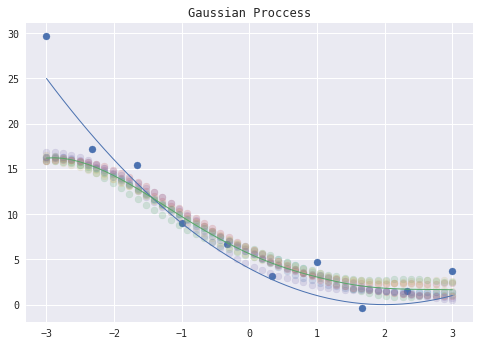

In [2]:
@np.vectorize
def foo(x):
    return (x-2.)**2

plt.plot(Xt:=np.linspace(-3, 3, 50)[:, np.newaxis], foo(Xt))
m = GaussianProcessRegressor(
    alpha=1.,
    kernel=kernels.Matern(),
)
m.fit(X:=np.linspace(-3, 3, 10)[:, np.newaxis], y:=foo(X[:, 0])+np.random.normal(scale=2., size=len(X)))
plt.scatter(X, y)
plt.plot(Xt, yt:=m.predict(Xt))
for i in range((samples:=m.sample_y(Xt, 10)).shape[-1]):
    plt.scatter(Xt, samples[:, i], alpha=0.2)
plt.title('Gaussian Proccess')
_=_

### Natural Cubic Spline

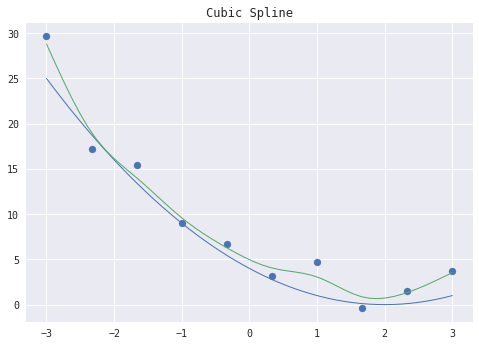

In [3]:
plt.plot(Xt, foo(Xt))
plt.scatter(X, y)

m = CubicSmoothingSpline(X[:, 0], y)
plt.plot(Xt[:, 0], yt:=m.spline(Xt[:, 0]))
plt.title('Cubic Spline')
_=_

### GAM

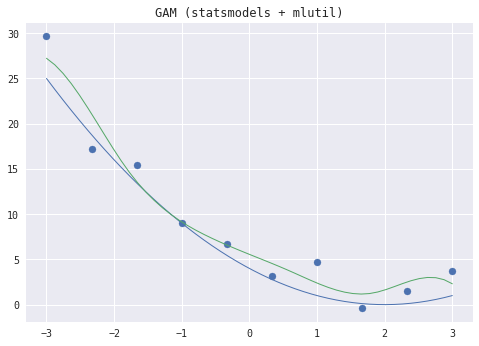

In [4]:
plt.plot(Xt, foo(Xt))
plt.scatter(X, y)

m = GAM1()
m.fit(X, y)
plt.plot(Xt, yt:=m.predict(Xt))
plt.title('GAM (statsmodels + mlutil)')
_=_

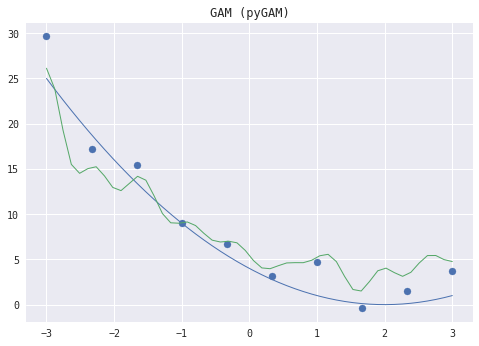

In [5]:
plt.plot(Xt, foo(Xt))
plt.scatter(X, y)

m = GAM2(lam=0.025)
# m.gridsearch(X, y, objective='AIC')
m.fit(X, y)
plt.plot(Xt, yt:=m.predict(Xt))
plt.title('GAM (pyGAM)')
_=_

## Multivariate

### Gaussian Process

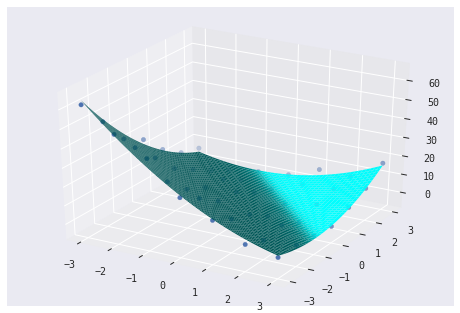

In [6]:
# @np.vectorize
def foo(x, y):
    return (x+y-2.)**2

def x_to_features(arr):
    return np.array([[x, y] for x, y in itertools.product(arr, arr)])

def x_to_meshgrid(arr):
    return np.meshgrid(arr, arr)

def y_to_meshgrid(arr):
    n = int(np.sqrt(len(arr)))
    assert n**2 == len(arr)
    return np.reshape(arr, (n, n))

def to_meshgrid(X):
    assert X.shape[1] == 2
    new_dim = np.sqrt(2500)

_X = np.linspace(-3, 3, 7)
_Xt = np.linspace(-3, 3, 50)

X = x_to_features(_X)
X_mg = x_to_meshgrid(_X)
Xt = x_to_features(_Xt)
Xt_mg = x_to_meshgrid(_Xt)

y = foo(X[:, 0], X[:, 1]) + np.random.normal(scale=2., size=len(X))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*X_mg, y)
ax.plot_surface(*Xt_mg, foo(*Xt_mg), color='cyan')

_=_

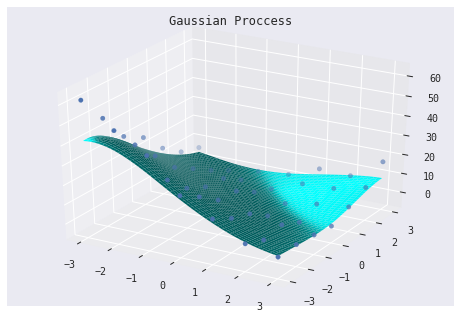

In [7]:
m = GaussianProcessRegressor(
    alpha=1.,
    kernel=kernels.Matern(),
)
m.fit(X, y)
yt = m.predict(Xt)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*X_mg, y)
ax.plot_surface(*Xt_mg, y_to_meshgrid(yt), color='cyan')
# for i in range((samples:=m.sample_y(Xt, 10)).shape[-1]):
#     plt.scatter(Xt, samples[:, i], alpha=0.2)
plt.title('Gaussian Proccess')
_=_

### Natural Cubic Spline

**Note:** only works with X mesh grid

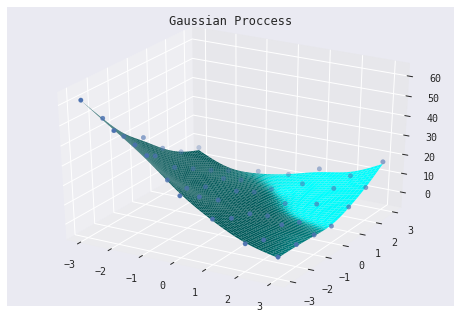

In [8]:
m = NdGridCubicSmoothingSpline([_X, _X], y_to_meshgrid(y))
yt = m.spline([_Xt, _Xt])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*X_mg, y)
ax.plot_surface(*Xt_mg, yt, color='cyan')
plt.title('Gaussian Proccess')
_=_

### GAM

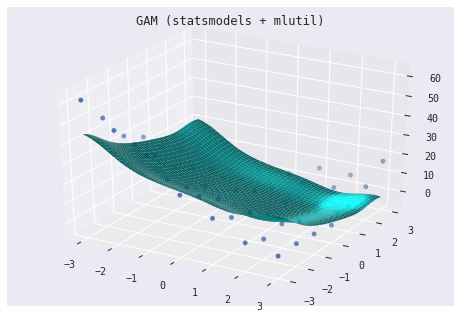

In [9]:
m = GAM1()
m.fit(X, y)
yt = m.predict(Xt)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*X_mg, y)
ax.plot_surface(*Xt_mg, y_to_meshgrid(yt), color='cyan')
plt.title('GAM (statsmodels + mlutil)')
_=_

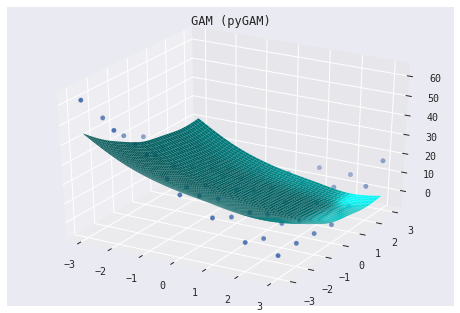

In [10]:
m = GAM2(lam=0.025)
m.fit(X, y)
yt = m.predict(Xt)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*X_mg, y)
ax.plot_surface(*Xt_mg, y_to_meshgrid(yt), color='cyan')
plt.title('GAM (pyGAM)')
_=_